# *Deepfake Video Detector Project*

# Approach

* Using Cnn+Lstm Hybrid Approach
* resnet50 for cnn and biLSTM for Lstm
* why hybrid?? only cnn would capture the facial feature but fail to see the frame by frame difference which is captured by LSTMS which are rnn (recurrent neural network) specially designed to take features from multiple sequential data
* applying online augmentation
* adams optimizer
* early stopping

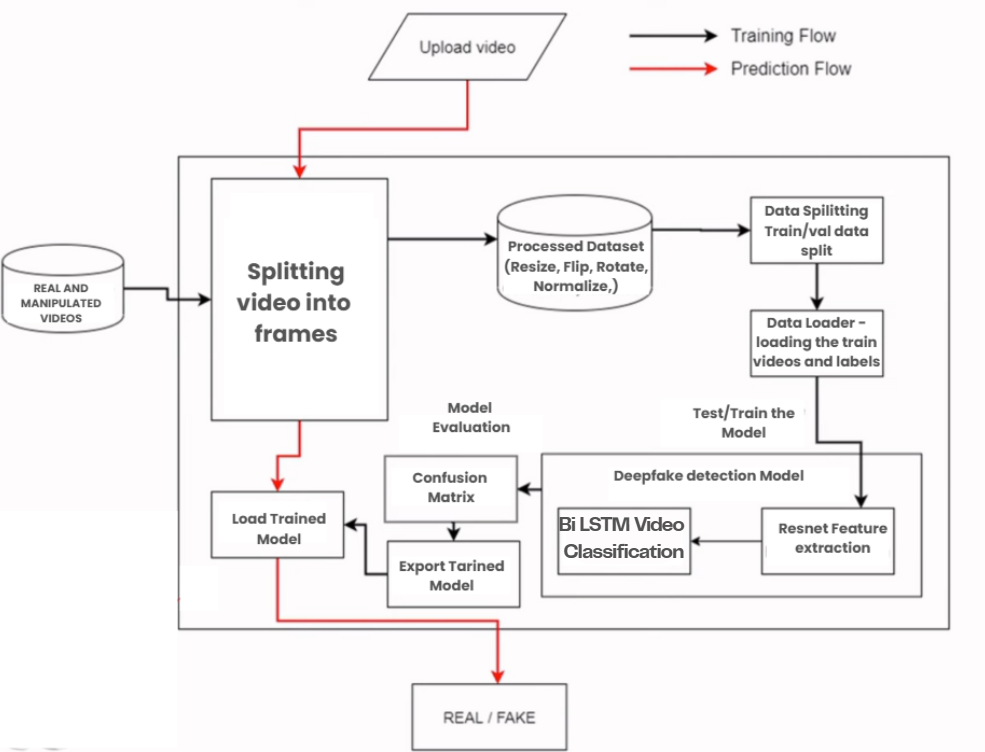
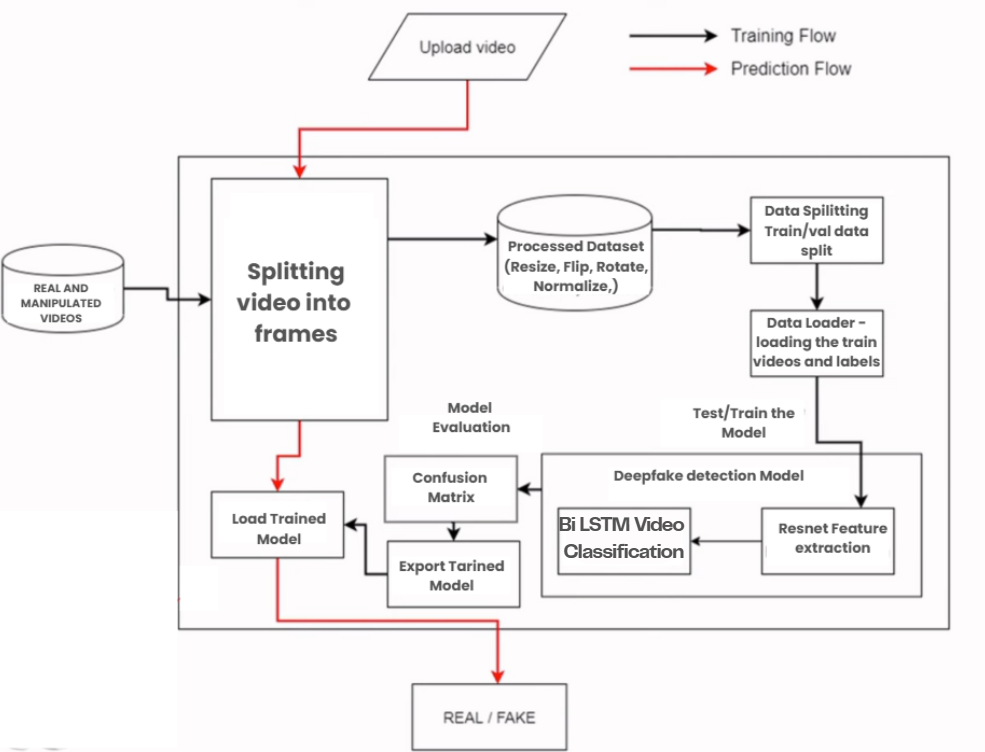
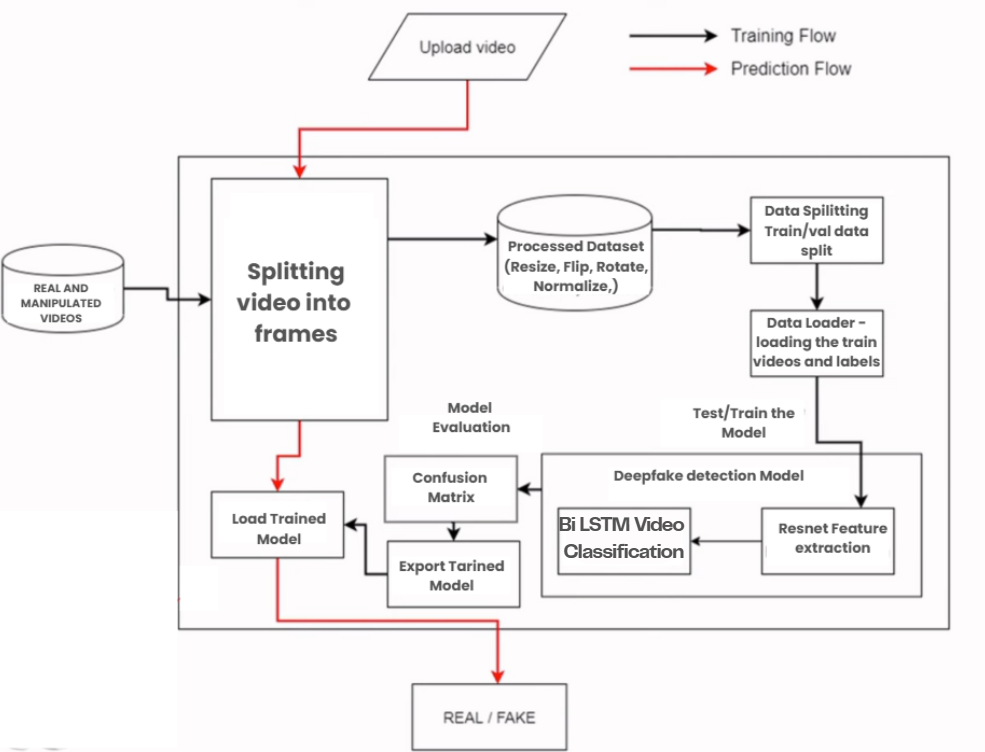

# Results

* 91.26% val accuracy


# Limitations

* for now only trained on 7gb data of videos.
* cannot take input videos which are too short
* still need some corrections despite val 91% accuracy

# **Codeflow**

# Import Statements

In [3]:
import numpy as np
import pandas as pd 
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split , Dataset
from torchvision import datasets, transforms,models
import timm
from PIL import Image
import glob

# Defining Directories

In [4]:
# Directories for real and manipulated videos
real_videos_dir = "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_original sequences"
manipulated_videos_dir = "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_manipulated_sequences/DFD_manipulated_sequences"

# Output directories for extracted frames
output_real_dir = "/kaggle/working/frames/real"
output_manipulated_dir = "/kaggle/working/frames/manipulated"


# Make sure output directories exists

In [5]:

os.makedirs(output_real_dir, exist_ok=True)
os.makedirs(output_manipulated_dir, exist_ok=True)

# Extraction of Frames from videos

In [6]:
def extract_frames_from_videos(videos_dir, output_dir, label, max_videos=400, offset=0):
    video_files = [f for f in os.listdir(videos_dir) if f.endswith(('.mp4', '.avi', '.mov', '.mkv'))]
    video_files = sorted(video_files)[offset:offset + max_videos]  # Slice the list

    for video_file in video_files:
        video_path = os.path.join(videos_dir, video_file)

        # Create a subfolder for this video
        video_folder_name = os.path.splitext(video_file)[0]
        video_output_dir = os.path.join(output_dir, label, video_folder_name)
        os.makedirs(video_output_dir, exist_ok=True)

        cap = cv2.VideoCapture(video_path)
        frame_count = 0
        success, image = cap.read()

        while success:
            if frame_count % int(cap.get(cv2.CAP_PROP_FPS)) == 0:
                frame_filename = f"frame{frame_count // int(cap.get(cv2.CAP_PROP_FPS))}.jpg"
                frame_path = os.path.join(video_output_dir, frame_filename)
                cv2.imwrite(frame_path, image)
            success, image = cap.read()
            frame_count += 1

        cap.release()


# Extract first 400 Real & Fake videos

In [7]:
# round one 
extract_frames_from_videos(real_videos_dir, output_real_dir, "real", max_videos=400, offset=0)
extract_frames_from_videos(manipulated_videos_dir, output_manipulated_dir, "manipulated", max_videos=400, offset=0)

#round two
# extract_frames_from_videos(real_videos_dir, output_real_dir, "real", max_videos=400, offset=400)
# extract_frames_from_videos(manipulated_videos_dir, output_manipulated_dir, "manipulated", max_videos=400, offset=400)

# Custom Dataset for our model

In [8]:

class VideoFrameSequenceDataset(Dataset):
    def __init__(self, root_dir, sequence_len=10, transform=None):
        self.samples = []
        self.sequence_len = sequence_len
        self.transform = transform
        self.class_to_idx = {'real': 0, 'manipulated': 1}

        for class_label in ['real', 'manipulated']:
            # Go one level deeper: e.g., /kaggle/working/frames/real/real/
            class_dir = os.path.join(root_dir, class_label, class_label)
            if not os.path.exists(class_dir):
                print(f"Warning: class_dir not found → {class_dir}")
                continue

            for video_folder in sorted(os.listdir(class_dir)):
                video_folder_path = os.path.join(class_dir, video_folder)
                frame_paths = sorted(glob.glob(os.path.join(video_folder_path, '*.jpg')))
                if len(frame_paths) >= sequence_len:
                    self.samples.append((frame_paths[:sequence_len], self.class_to_idx[class_label]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        frame_paths, label = self.samples[idx]
        frames = []

        for path in frame_paths:
            image = Image.open(path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            frames.append(image)

        video_tensor = torch.stack(frames)  # shape: [sequence_len, 3, 224, 224]
        return video_tensor, torch.tensor(label)


# Online Transformations

In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# Training and Val data split & Data Loaders

In [10]:


dataset_dir = "/kaggle/working/frames"

full_dataset = VideoFrameSequenceDataset(root_dir=dataset_dir, sequence_len=10, transform=transform)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)


# Hybrid cnn + biLSTM model definition

In [2]:


class CNN_BiLSTM(nn.Module):
    def __init__(self, hidden_dim=256, num_layers=1, num_classes=2):
        super(CNN_BiLSTM, self).__init__()
        # Load pretrained ResNet-50 and remove final FC layer
        resnet = models.resnet50(pretrained=True)
        self.cnn = nn.Sequential(*list(resnet.children())[:-1])  # Output: [B, 2048, 1, 1]

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size=2048, hidden_size=hidden_dim, num_layers=num_layers,
                            batch_first=True, bidirectional=True)

        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # x2 for bidirectional

    def forward(self, x):
        # x: [batch_size, seq_len, 3, 224, 224]
        batch_size, seq_len, C, H, W = x.size()
        cnn_features = []

        for t in range(seq_len):
            frame = x[:, t, :, :, :]  # [B, 3, 224, 224]
            feat = self.cnn(frame).view(batch_size, -1)  # [B, 2048]
            cnn_features.append(feat)

        features = torch.stack(cnn_features, dim=1)  # [B, seq_len, 2048]
        lstm_out, _ = self.lstm(features)  # [B, seq_len, hidden_dim*2]
        out = self.fc(lstm_out[:, -1, :])  # Output from the last time step
        return out

# Example usage:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = CNN_BiLSTM(hidden_dim=256, num_layers=1, num_classes=2).to(device)


# Training LOOP

In [12]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_BiLSTM(hidden_dim=256, num_layers=1, num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

num_epochs = 20
best_val_accuracy = 0
patience = 5
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for videos, labels in train_loader:
        videos, labels = videos.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(videos)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_acc = 100 * correct_train / total_train
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%")

    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for videos, labels in val_loader:
            videos, labels = videos.to(device), labels.to(device)
            outputs = model(videos)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_acc = 100 * correct_val / total_val
    print(f"Validation Accuracy: {val_acc:.2f}%")

    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model.state_dict(), 'best_cnn_lstm.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    scheduler.step()

print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 216MB/s]


Epoch [1/20], Loss: 0.5333, Train Acc: 71.79%
Validation Accuracy: 79.87%
Epoch [2/20], Loss: 0.4344, Train Acc: 81.25%
Validation Accuracy: 83.22%
Epoch [3/20], Loss: 0.3461, Train Acc: 86.66%
Validation Accuracy: 87.92%
Epoch [4/20], Loss: 0.3692, Train Acc: 85.30%
Validation Accuracy: 85.91%
Epoch [5/20], Loss: 0.3215, Train Acc: 89.02%
Validation Accuracy: 87.92%
Epoch [6/20], Loss: 0.3142, Train Acc: 88.85%
Validation Accuracy: 91.28%
Epoch [7/20], Loss: 0.2652, Train Acc: 90.20%
Validation Accuracy: 91.28%
Epoch [8/20], Loss: 0.2558, Train Acc: 90.88%
Validation Accuracy: 89.93%
Epoch [9/20], Loss: 0.2138, Train Acc: 93.41%
Validation Accuracy: 91.28%
Epoch [10/20], Loss: 0.2118, Train Acc: 92.40%
Validation Accuracy: 89.26%
Epoch [11/20], Loss: 0.2218, Train Acc: 92.91%
Validation Accuracy: 89.93%
Early stopping triggered.
Best Validation Accuracy: 91.28%


# Classification Report & Accuracy Score

In [18]:
from sklearn.metrics import classification_report, accuracy_score

# Load the best model
model.load_state_dict(torch.load('best_cnn_lstm.pth', weights_only=True))
model.eval()

all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate classification metrics
print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=['Real', 'Manipulated']))

# Optionally print accuracy separately
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")


Classification Report:
              precision    recall  f1-score   support

        Real       0.95      0.86      0.90        70
 Manipulated       0.88      0.96      0.92        79

    accuracy                           0.91       149
   macro avg       0.92      0.91      0.91       149
weighted avg       0.92      0.91      0.91       149

Accuracy: 91.28%


# Confusion Matrix

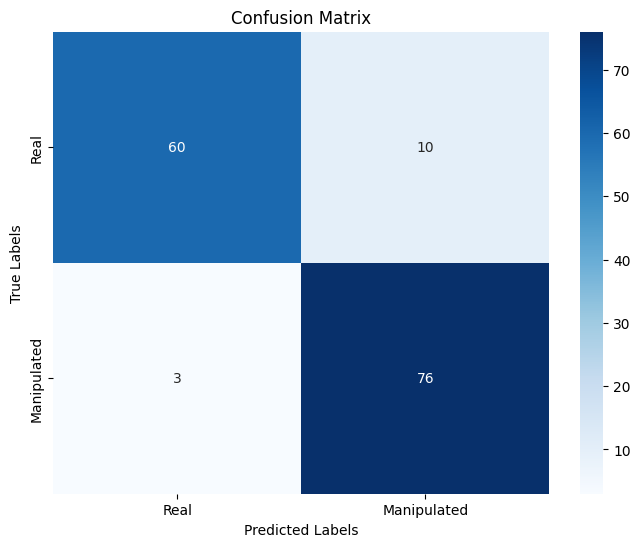

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Manipulated'], yticklabels=['Real', 'Manipulated'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Testing Function

In [3]:
import torch
import cv2
import os
from torchvision import transforms
from PIL import Image

# Preprocessing (same as used in training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def predict_single_video(video_path, device, sequence_len=10):
    # Load model
    model = CNN_BiLSTM(hidden_dim=256, num_layers=1, num_classes=2).to(device)
    model_path = "/kaggle/input/best-cnn-lstm-1/best_cnn_lstm (1).pth"
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    model.eval()

    # Extract 1 frame per second
    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_list = []
    frame_count = 0

    while len(frame_list) < sequence_len:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % fps == 0:
            # Convert to PIL and apply transforms
            image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            image = transform(image)
            frame_list.append(image)
        frame_count += 1
    cap.release()

    if len(frame_list) < sequence_len:
        print("❌ Not enough frames in the video. Try with a longer video.")
        return None

    # Create input tensor [sequence_len, 3, 224, 224] → [1, sequence_len, 3, 224, 224]
    video_tensor = torch.stack(frame_list).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        outputs = model(video_tensor)
        _, predicted = torch.max(outputs, 1)
        label = "Real" if predicted.item() == 0 else "Manipulated"
        print(f"🎬 Prediction: {label}")
        return label



# Testing the model

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
video_path = "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_original sequences/15__exit_phone_room.mp4"
predict_single_video(video_path, device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 230MB/s]


🎬 Prediction: Real


'Real'

In [5]:
video_path = "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_manipulated_sequences/DFD_manipulated_sequences/01_20__walking_and_outside_surprised__OTGHOG4Z.mp4"
predict_single_video(video_path, device)

🎬 Prediction: Manipulated


'Manipulated'

In [6]:
real_video_path = "/kaggle/input/celeb-df-v2/Celeb-real/id0_0000.mp4"
manupulated_video_path = "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_manipulated_sequences/DFD_manipulated_sequences/01_20__walking_and_outside_surprised__OTGHOG4Z.mp4"
predict_single_video(real_video_path, device)
predict_single_video(manupulated_video_path, device)

🎬 Prediction: Real
🎬 Prediction: Manipulated


'Manipulated'